In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import sys
import numpy as np
import glob
import matplotlib
import torch

sys.path.insert(1,"/home/showalte/research/prob_seq_queries/")
from seq_queries.utils import read_pkl, write_pkl

In [2]:
sampling_methods = ["importance_sampling","beam_search_is_hybrid"]
lens = [(17,20)]
temps = [1]
data_paths = "../data/{}/shakespeare/is_v_hybrid/val-dl_{}_{}h_{}s_{:03}t.pkl"

In [39]:
gt = read_pkl("../data/ground_truth/shakespeare/val_dl/val-dl_shakespeare_ground-truth_18h_20s.pkl")
gt_term = torch.gather(gt['dist_lower_bound'],1,gt['excluded_terms'].unsqueeze(-1)).squeeze().numpy()
print(gt_term.shape)
print(gt['dist_lower_bound'].shape)

(2287,)
torch.Size([2287, 68])


In [9]:
print(imp_samp['sample_estimates'].shape)
excluded_terms = imp_samp['excluded_terms'].repeat((imp_samp['sample_estimates'].shape[1],1)).T
print(excluded_terms.shape)

torch.Size([2287, 100, 68])
torch.Size([2287, 100])


In [5]:
datas = []
for h,s in lens:
    for t in temps:
        data = []
        for sampling_method in sampling_methods:
            curr_data_path = data_paths.format(sampling_method, sampling_method,h,s,t)
            curr_data = read_pkl(curr_data_path)
            data.append(curr_data)
        datas.append(data)

In [6]:
imp_samp, hybrid = datas[-1]
imp_data = torch.gather(imp_samp['sample_est_var'],1,imp_samp['excluded_terms'].unsqueeze(-1)).squeeze().numpy()
hybrid_data = torch.gather(hybrid['hybrid_var'],1,hybrid['excluded_terms'].unsqueeze(-1)).squeeze().numpy()
print(imp_data.shape,hybrid_data.shape)

(2287,) (2287,)


In [12]:
hybrid.keys()

dict_keys(['bs_lower_bound', 'is_estimate', 'hybrid_bs_is_estimate', 'model_runs', 'hybrid_var', 'hybrid_mean', 'num_beams', 'true_coverage', 'restricted_coverage', 'metadata', 'excluded_terms'])

In [30]:
imp_samp, hybrid = datas[-1]
excluded_terms = imp_samp['excluded_terms'].repeat((imp_samp['sample_estimates'].shape[1],1)).T
imp_data = torch.gather(imp_samp['sample_estimates'].var(dim=1),1,imp_samp['excluded_terms'].unsqueeze(-1)).squeeze().numpy()
hybrid_data = torch.gather(hybrid['hybrid_bs_is_estimate'].var(dim=1),1,hybrid['excluded_terms'].unsqueeze(-1)).squeeze().numpy()
print(imp_data.shape,hybrid_data.shape)

(2287,) (2287,)


In [33]:
print(hybrid_data.mean(),imp_data.mean())

0.00038501713 0.030616736


In [34]:
print(imp_diffs.mean(), hybrid_diffs.mean())

0.06963884 0.06752193


In [40]:
for i in range(10):
    print(imp_diffs[i],hybrid_diffs[i],gt_term[i])

0.41477793 0.4314054 0.5485329
0.08005831 0.051857233 0.47581723
0.009035334 0.0045819134 0.04336934
0.0029433295 0.0061441064 0.07827563
0.13425499 0.13531154 0.20941703
0.01711917 0.017203957 0.15629938
0.008817643 0.021812975 0.34911865
0.0023613442 0.002050301 0.022637147
0.54160905 0.535424 0.86487377
0.035050035 0.0020227432 0.8637062


In [29]:
imp_diffs = np.abs(imp_data - gt_term)
hybrid_diffs = np.abs(hybrid_data - gt_term)
print(np.median(imp_diffs), np.median(hybrid_diffs))
diffs = np.abs(imp_diffs -hybrid_diffs)/imp_diffs
print(np.median(diffs))
# plt.hist(diffs,bins = 100)
# plt.xlim(-0.1,20)
# plt.show()

0.019351114 0.015930444
0.31801456


In [140]:
# print(imp_data.mean())
diffs = (imp_data - hybrid_data)/(imp_data + 1e-10)

In [141]:
imp_data.max()/hybrid_data.max()

54.941673

In [142]:
diffs[diffs<0] = 0

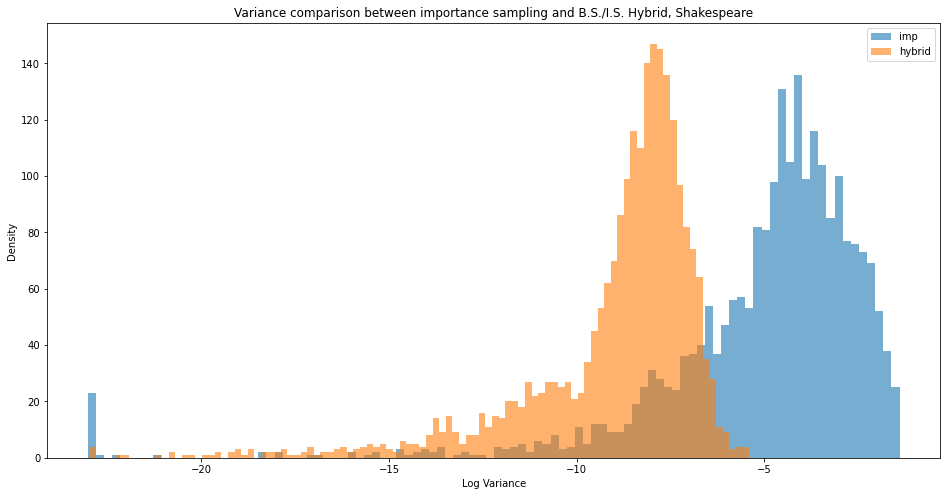

In [31]:
plt.figure(figsize=(16,8))
plt.hist(np.log(imp_data + 1e-10), label = "imp", bins = 100,alpha=0.6)
plt.hist(np.log(hybrid_data + 1e-10), label = "hybrid",bins=100,alpha=0.6)
plt.legend()
plt.xlabel("Log Variance")
plt.ylabel("Density")
plt.title("Variance comparison between importance sampling and B.S./I.S. Hybrid, Shakespeare")
plt.show()

# plt.hist(diffs.numpy(),bins=100)

0.95586836


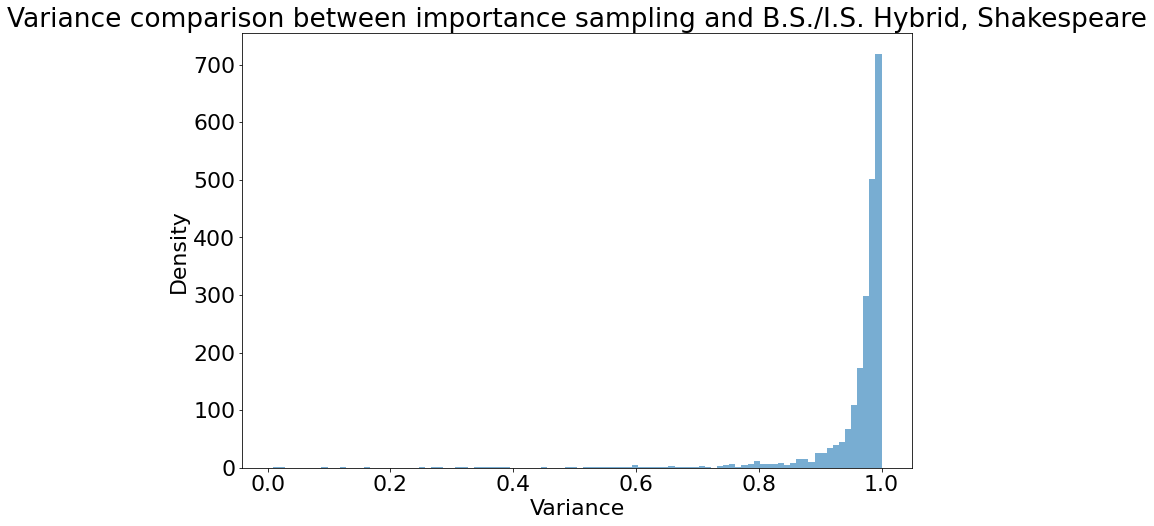

In [145]:
diffs = (imp_data - hybrid_data + 1e-10)/(imp_data + 1e-10)
diffs = diffs[diffs>=0]
print(diffs.mean())
plt.figure(figsize=(12,8))
plt.hist(diffs, label = "hybrid",bins=100,alpha=0.6)
plt.xlabel("Variance")
plt.ylabel("Density")
plt.title("Variance comparison between importance sampling and B.S./I.S. Hybrid, Shakespeare")
plt.show()


## Model iterations v. MAE

In [9]:
print(os.listdir("../"))

['.git', 'README.md', 'requirements.txt', '.ipynb_checkpoints', 'data', 'setup.sh', 'models', '__pycache__', 'archive', '.gitignore', 'seq_queries', 'test', 'config', 'notebooks', 'logs', 'imgs', 'scripts', 'scratch.py', '.vim', 'LICENSE']


In [120]:
methods = ['ground_truth','importance_sampling','beam_search_is_hybrid']
dataset = 'shakespeare'
experiment='val_dl'
lengths = [(18,20)]

data_dict = {}
for length in lengths:
    for method in methods:
        h,s = length
        path_template = f"../data/{method}/{dataset}/{experiment}/{experiment.replace('_','-')}_{dataset}_{method.replace('_','-')}_{h}h_{s}s*.pkl"
        print(path_template)
        pot_paths = glob.glob(path_template)
        assert len(pot_paths) == 1,\
            f"Paths: {pot_paths}"
        data_dict[method] = read_pkl(pot_paths[0])
    

../data/ground_truth/shakespeare/val_dl/val-dl_shakespeare_ground-truth_18h_20s*.pkl
../data/importance_sampling/shakespeare/val_dl/val-dl_shakespeare_importance-sampling_18h_20s*.pkl
../data/beam_search_is_hybrid/shakespeare/val_dl/val-dl_shakespeare_beam-search-is-hybrid_18h_20s*.pkl


In [121]:
print(data_dict['ground_truth']['dist_lower_bound'].shape)
# print(data_dict['beam_search_is_hybrid'].keys())

torch.Size([2287, 68])


In [134]:
def plot_against_samples(data_dict, sub_estimates = [10,100,1000,10000]):
    sub_estimates = data_dict['importance_sampling']['metadata']['sub_estimates']
    importance_estimates= data_dict['importance_sampling']['sample_estimates']
    excluded_terms = data_dict['beam_search_is_hybrid']['excluded_terms']
    gt= torch.gather(data_dict['ground_truth']['dist_lower_bound'],1,excluded_terms.unsqueeze(-1)).squeeze()
    hybrid_estimates= data_dict['beam_search_is_hybrid']['hybrid_bs_is_estimate']
    # hybrid_estimates= torch.gather(data_dict['beam_search_is_hybrid']['hybrid_var'],1,excluded_terms.unsqueeze(-1)).flatten()
    # hybrid_estimates = torch.stack([
    #     torch.gather(hybrid_estimates[:,:s].var(dim=1),1,
    #                  excluded_terms.unsqueeze(-1))
    #                  for s in sub_estimates],dim=1).squeeze()
    # print(gt[15], hybrid_estimates[15], importance_estimates[15])
    importance_diffs = torch.abs((importance_estimates[:,:-1] - gt.unsqueeze(-1)))
    hybrid_diffs = torch.abs(hybrid_estimates - gt.unsqueeze(-1))
    total_diffs = abs(importance_diffs - hybrid_diffs)/importance_diffs
    print((hybrid_diffs > importance_diffs).sum()/(hybrid_diffs.shape[0] * hybrid_diffs.shape[1]))
    print(importance_diffs.mean(), hybrid_diffs.mean())
    print((importance_diffs - hybrid_diffs).max())
    print(total_diffs.max(), total_diffs.min(),total_diffs.median())
    # importance_diffs = data_dict['importance_sampling']['sample_est_var']
    # print(data_dict['beam_search_is_hybrid']['hybrid_var'].shape)
    # hybrid_diffs = data_dict['beam_search_is_hybrid']['hybrid_var']
    # hybrid_diffs = torch.abs(hybrid_estimates - gt.unsqueeze(-1))/hybrid_estimates
    # print(((importance_diffs[:,2] - hybrid_diffs[:,2])/(importance_diffs[:,2])).mean())
    # importance_diffs = data_dict['importance_sampling']['sample_est_var']
    # hybrid_diffs = hybrid_estimates
    # hybrid_diffs = data_dict['beam_search_is_hybrid']['hybrid_var']
    
    total_df = pd.DataFrame(total_diffs, columns=sub_estimates[:-1])
    total_df = pd.melt(total_df, value_vars=sub_estimates[:-1])
    total_df['method'] = 'reduction'
    # importance_df = pd.DataFrame(importance_diffs, columns=sub_estimates)
    # importance_df = pd.melt(importance_df, value_vars=sub_estimates)
    # importance_df['method'] = 'importance_sampling'
    # hybrid_df = pd.DataFrame(hybrid_diffs, columns=sub_estimates[:-1])
    # hybrid_df = pd.melt(hybrid_df, value_vars=sub_estimates[:-1])
    # hybrid_df['method'] = 'hybrid_search_sample'
    # print(hybrid_df.shape, importance_df.shape)
    # df = pd.concat([importance_df,hybrid_df],ignore_index = True,axis=0)
    # print(df.head())
    df = total_df
    
    # plt.figure(figsize=(12,8))
    # matplotlib.rcParams.update({'font.size': 22})
    # fig,ax = plt.subplots(figsize=(15,8))
    # sns.boxplot(x ='variable',y='value',hue='method',data=df)
    # plt.xlabel("Number of samples")
    # plt.ylabel(r"MAE of estimate $p(x_k = \phi, x_{1:k-1} \neq \phi|H_t)$")
    # plt.title("Shakespeare, Seq. Len=2 Hybrid v. Importance Sampling")
    # plt.xticks(rotation=45)
    # plt.ylim(-0.1,2.5)
    # plt.tight_layout()


In [135]:
plot_against_samples(data_dict)

tensor(0.3305)
tensor(0.0135) tensor(0.0080)
tensor(0.3677)
tensor(1765.0699) tensor(7.4610e-06) tensor(0.7845)
